# Ответы на важные вопросы

## 1. Разбиение данных на обучение и валидацию
Разбиваю множество `id юзеров` на части train и valid в соотношении `0.7/0.3`.
Я использую `юзеров` для разбиения потому, что создаю эмбеддинги для них, а не для фильмов.
Для фильмов же используются вектора полученные из `genome-scores`.
## 2. Выбор и обоснование метрики
В качестве метрики я использую `косинусное расстояние`, а именно реализацию этой метрики в `sklearn`.
Вектора похожих фильмов могут быть далеко друг от друга по MSE, но быть направлены в одну сторону. 
Например, если векторы разные по длине, но направлены в одну сторону, то MSE выдаст большое значение.
Нам же важна именно сонаправленность векторов. Интуиция здесь такая, что если пользователи A и B любят "Историю игрушек", то мы хотим советовать похожие фильмы им обоим, не смотря на то, что B любит этот фильм сильнее (Вектор B больше по модулю).
## 3. Архитектура нейронной сети
Создаю кастомную архитектуру на основе BERT потому, что BERT наиболее популярная модель, основанная на трансформере. 
BERT показывает хорошие результаты во многих задачах ML, в частности в RecSys.
За основу беру `bert-base-cased` из `huggingface` для задачи классификации на 64 класса, где 64 это размерность эмбеддигов. Беру из него нужны слои и создаю свой класс `BertForUsers(nn.Module)`. Я делаю это для того, что подавать на вход модели то, что мне нужно, а не input_ids, как принято у моделей из `huggingface`.
## 4. Обучение и валидация
У юзера есть видео, которые он оценивал или к которым писал комментарий. Пусть `X` - множество векторов этих видео. Разделим `X` на `X_train` и `next_vector`, где `next_vector` это один вектор. При чем, в качестве `next_vector` возьмем вектор фильма, которому юзер дал наивысшую оценку. Таким образом `next_vector` это самый подходящий фильм для юзера и мы будем стараться сделать вектор для юзера как можно более похожим на `next_vector`.

На вход модель подаются векторы из `X_train` и модель учится предсказывать вектор `next_vector`. В качестве лосса используется `torch.nn.CosineEmbeddingLoss()`.

Предсказанный вектор `next_vector_prediction` будем считать вектором юзера.

Из`genome-scores` получим вектора для видео и положим их в `relevance_matrix`. Будем подавать эти вектора на вход модели `BertForUsers(nn.Module)`, а на выходе получать вектор размерности 64, по которому считаем лосс с `next_vector`, который тоже находится в `relevance_matrix`.

Однако заместо обычных векторов из `relevance_matrix`, будем использовать 3 типа фичей:
- `ranking`, который юзер дал текущему видео
- `movie genre`
- вектор из `relevance_matrix`

Таким образом, если юзер низко оценил видео, то оно почти не будет участвовать в предсказании следующего видео. Также мы учитываем какой жанр был у видео, ведь если юзер плохо оценил определенные жанры, то фильмы такого жанра почти не должны влиять на предсказание следующего видео.

- `ranking` - множитель для вектора
- `movie genre` - вектор размерности 20, полученный из жанров как из категориальных фичей.

Указанные 3 типа фичей соединим с помощью конкатенации и уменьшением размерности.
## 5. Воспроизводимость
- Данный ноутбук был сделан на `kaggle`, так как `colab` зависает при работе с большими ноутбуками.
- Необходимые сохраненные результаты можно найти в соответствующих датасетах на `kaggle`. По ссылкам: [data-for-collate-fn](https://www.kaggle.com/datasets/yaskevichmisha/data-for-collate-fn), [datadet-path](https://www.kaggle.com/datasets/yaskevichmisha/dataset-path)
- В разделе **Data preparation** будет выполняться left join для больших таблиц, что требует **~17GB RAM**. Если RAM не хватает, то нужно пропустить этот шаг и перейти к шагу **Make datasets for Trainer**, где скачиваются необходимые для обучения результаты.

## 6. Результаты
Вектор полученный для юзера имеет косинусное расстояние с таргетом около 0.14, где таргет это вектор фильма, который понравился юзеру больше всего.


# Imports

In [2]:
!pip install transformers==4.28.0

In [3]:
import os
import pandas as pd
from pathlib import Path
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm, trange
from sklearn.decomposition import TruncatedSVD
import torch
from torch import nn
from transformers import Trainer
import shutil
from sklearn.utils import shuffle
from torch.utils.data import Dataset, DataLoader
from transformers import TrainingArguments, Trainer
import transformers
import pickle
from sklearn.metrics.pairwise import cosine_distances

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
seed = 42
dataset_path = Path('/kaggle/input/dataset-path/dataset_path')
np.random.seed(seed)
batch_size = 8
max_seq_len = 512
emb_dim = 64
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# EDA

### Ratings

In [11]:
ratings_df = pd.read_csv(dataset_path / 'ratings.csv')
ratings_df

,userId,movieId,rating,timestamp
0,1,307,3.5,1256677221
1,1,481,3.5,1256677456
2,1,1091,1.5,1256677471
3,1,1257,4.5,1256677460
4,1,1449,4.5,1256677264
...,...,...,...,...
27753439,283228,8542,4.5,1379882795
27753440,283228,8712,4.5,1379882751
27753441,283228,34405,4.5,1379882889
27753442,283228,44761,4.5,1354159524


Какую оценку в среднем ставит каждый из юзеров? Каждый оценивает по своему, кто-то занижает а кто-то завышает оценки, поэтому будет полезно знать матожидание оценки определенного юзера.

In [14]:
ratings_df['count'] = np.ones((len(ratings_df)))
avg_rating_df = ratings_df[['userId', 'rating', 'count']].groupby(by='userId').sum()
avg_rating_df['avg'] = avg_rating_df['rating'] / avg_rating_df['count']
avg_rating_df_sorted = avg_rating_df.sort_values(by='avg')
avg_rating_df_sorted

,rating,count,avg
userId,,,
246381,0.5,1.0,0.5
117977,10.0,20.0,0.5
163134,0.5,1.0,0.5
61279,0.5,1.0,0.5
280246,7.5,15.0,0.5
...,...,...,...
43957,5.0,1.0,5.0
180642,5.0,1.0,5.0
180651,5.0,1.0,5.0


Из таблицы видно, что некоторые юзеры ставят много низких оценок, значит если какому то видео такой юзер поставит 3, то ему понравился фильм. 

Также можно увидеть, что некоторые ставят только 5. Оценки такого юзера не репрезентативны и мы не можем понять что ему понравилось, а что нет.

Ниже мы можем увидеть общую картину. Большинство людей оценивают видео адекватно. Матожидание их оценок находится в диапазоне [3, 4]. 

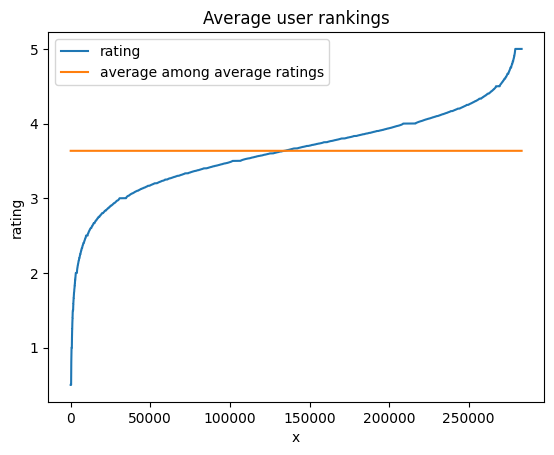

In [15]:
fig, ax = plt.subplots()
size = avg_rating_df_sorted.shape[0]
line1, = ax.plot(np.arange(size), avg_rating_df_sorted['avg'], label='rating')
line2, = ax.plot(np.arange(size), [avg_rating_df_sorted['avg'].mean()] * size, label='average among average ratings')
ax.legend(handles=[line1, line2])

ax.set_xlabel('x')
ax.set_ylabel('rating')
ax.set_title('Average user rankings')

plt.show()

Переведем rating в диапазон [-1, -1] для каждого юзера. Тогда оценкам можно будет доверять независимо от того насколько хорошо юзер оценивает в среднем. 

Таким образом если оценка фильма -1, то при создании вектора юзера мы возьмем для этого фильма вектор, направленный в противоположную сторону. Это будет означать, что предпочтения юзера находятся в противоположной части векторного пространства.

In [16]:
rating = np.array(ratings_df['rating'])

In [17]:
for i in trange(len(rating)):
    id = ratings_df['userId'][i]
    # вычитаем среднее
    rating[i] -= avg_rating_df['avg'][id]

100%|██████████| 27753444/27753444 [06:18<00:00, 73380.64it/s] 


In [18]:
ratings_df['rating'] = rating
ratings_df

,userId,movieId,rating,timestamp,count
0,1,307,0.187500,1256677221,1.0
1,1,481,0.187500,1256677456,1.0
2,1,1091,-1.812500,1256677471,1.0
3,1,1257,1.187500,1256677460,1.0
4,1,1449,1.187500,1256677264,1.0
...,...,...,...,...,...
27753439,283228,8542,0.159292,1379882795,1.0
27753440,283228,8712,0.159292,1379882751,1.0
27753441,283228,34405,0.159292,1379882889,1.0
27753442,283228,44761,0.159292,1354159524,1.0


In [19]:
max_rating_df = ratings_df[['userId', 'rating']].groupby(by='userId').max()

In [20]:
min_rating_df = ratings_df[['userId', 'rating']].groupby(by='userId').min()

In [21]:
# делим на максимум или минимум, чтобы перевести в диапазон [-1, 1]
for i in trange(len(rating)):
    id = ratings_df['userId'][i]
    if rating[i] > 0:
        if abs(max_rating_df['rating'][id]) < 0.00001:
            rating[i] = 0
        else:
            rating[i] /= max_rating_df['rating'][id]
    else:
        if abs(min_rating_df['rating'][id]) < 0.00001:
            rating[i] = 0
        else:
            rating[i] /= (-min_rating_df['rating'][id])

100%|██████████| 27753444/27753444 [10:28<00:00, 44136.93it/s]


In [22]:
min(rating), max(rating)

(-1.0, 1.0)

In [23]:
ratings_df['rating'] = rating
ratings_df

,userId,movieId,rating,timestamp,count
0,1,307,0.157895,1256677221,1.0
1,1,481,0.157895,1256677456,1.0
2,1,1091,-1.000000,1256677471,1.0
3,1,1257,1.000000,1256677460,1.0
4,1,1449,1.000000,1256677264,1.0
...,...,...,...,...,...
27753439,283228,8542,0.241611,1379882795,1.0
27753440,283228,8712,0.241611,1379882751,1.0
27753441,283228,34405,0.241611,1379882889,1.0
27753442,283228,44761,0.241611,1354159524,1.0


Переведем время из секунд в дни

In [24]:
seconds_in_day = 60 * 60 * 24
ratings_df['timestamp'] = ratings_df['timestamp'] // seconds_in_day
ratings_df

,userId,movieId,rating,timestamp,count
0,1,307,0.157895,14544,1.0
1,1,481,0.157895,14544,1.0
2,1,1091,-1.000000,14544,1.0
3,1,1257,1.000000,14544,1.0
4,1,1449,1.000000,14544,1.0
...,...,...,...,...,...
27753439,283228,8542,0.241611,15970,1.0
27753440,283228,8712,0.241611,15970,1.0
27753441,283228,34405,0.241611,15970,1.0
27753442,283228,44761,0.241611,15673,1.0


In [25]:
ratings_df['days'] = ratings_df['timestamp']
del ratings_df['timestamp']

Сохраним полученный rating.csv

In [26]:
ratings_df.to_csv('./rating_processed_first.csv', index=False)

### Tag genom (genome-scores.csv)

In [13]:
genome_scores_df = pd.read_csv(dataset_path / 'genome-scores.csv')
genome_scores_df

,movieId,tagId,relevance
0,1,1,0.02900
1,1,2,0.02375
2,1,3,0.05425
3,1,4,0.06875
4,1,5,0.16000
...,...,...,...
14862523,187595,1124,0.10700
14862524,187595,1125,0.05850
14862525,187595,1126,0.03800
14862526,187595,1127,0.10225


Проверим, что для каждого movie есть все 1128 тегов

In [14]:
genome_scores_df['count'] = np.ones((len(genome_scores_df)))
grouped_genome_scores = genome_scores_df[['movieId', 'relevance', 'count']].groupby(by='movieId').sum()

# заодно посчитаем average relevance
grouped_genome_scores['avg_relevance'] = grouped_genome_scores['relevance'] / grouped_genome_scores['count']
del grouped_genome_scores['relevance']
grouped_genome_scores

,count,avg_relevance
movieId,,
1,1128.0,0.161394
2,1128.0,0.120811
3,1128.0,0.091322
4,1128.0,0.084131
5,1128.0,0.091202
...,...,...
185435,1128.0,0.113705
185585,1128.0,0.100509
186587,1128.0,0.155586


In [15]:
grouped_genome_scores['count'].unique()[0]

1128.0

Получаем, что каждого movie есть все 1128 тегов.

#### Simple movie vectors

На основе genome-scores сделаем матрицу, размера [количество видео, количество тегов].

Тогда каждая строка будет векторным представлением видео.

In [16]:
movies_count = grouped_genome_scores.shape[0]
tags_count = int(grouped_genome_scores['count'].unique()[0])
relevance_matrix = np.ones((movies_count, tags_count))

In [17]:
movieId2index = {}
for i in trange(movies_count):
    start = i * tags_count
    end = (i + 1) * tags_count - 1
    relevance_matrix[i] = genome_scores_df.loc[start:end]['relevance']
    
    #сохраним маппинг movieId и индекса в relevance_matrix
    movie_id = genome_scores_df.loc[start:end]['movieId'][start]
    movieId2index[movie_id] = i

100%|██████████| 13176/13176 [00:01<00:00, 8566.87it/s]


In [33]:
os.mkdir('./dataset')
with open('./dataset/movieId2index.pkl', 'wb') as f:
    pickle.dump(movieId2index, f)

Оставим только те строки, в которых movie имеет вектор в `relevance_matrix`. Как можно увидеть ниже, мы удалили меньше 400к строк из 28M, так что о потерянных строках можно не переживать.

In [34]:
ratings_df = ratings_df[ratings_df['movieId'].isin(movieId2index)]
len(ratings_df)

27417362

In [35]:
# юзеры с одним видео не подходят для next-item prediction
cnts = ratings_df['userId'].value_counts()
bad_user_ids = set(cnts[cnts == 1].index)
len(bad_user_ids)

5612

In [36]:
# bad_users = ratings_df[ratings_df['userId'].isin(bad_user_ids)]
ratings_df = ratings_df[~ratings_df['userId'].isin(bad_user_ids)].reset_index(drop=True)
len(ratings_df)

27411750

Сохраним обработанный rating.csv

In [37]:
ratings_df.to_csv(dataset_path / 'ratings_processed.csv', index=False)

Загрузим обработанный ratings.csv

In [5]:
ratings_df = pd.read_csv(dataset_path / 'ratings_processed.csv')

### Tags

In [39]:
tags_df = pd.read_csv(dataset_path / 'tags.csv')
tags_df

,userId,movieId,tag,timestamp
0,14,110,epic,1443148538
1,14,110,Medieval,1443148532
2,14,260,sci-fi,1442169410
3,14,260,space action,1442169421
4,14,318,imdb top 250,1442615195
...,...,...,...,...
1108992,283206,73017,fun,1264379059
1108993,283206,73017,homoerotic subtext,1264379058
1108994,283206,73017,pacing,1264379058
1108995,283206,73017,plot,1264379058


### Movies

In [25]:
movies_df = pd.read_csv(dataset_path / 'movies.csv')
movies_df

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
58093,193876,The Great Glinka (1946),(no genres listed)
58094,193878,Les tribulations d'une caissière (2011),Comedy
58095,193880,Her Name Was Mumu (2016),Drama
58096,193882,Flora (2017),Adventure|Drama|Horror|Sci-Fi


Присутствует ли несбалансированность по жанрам? Допустим жанр A встречается в 90% случаев, тогда если 90% понравившихся юзеру фильмов будут иметь жанр A, то мы можем ошибочно предположить, что это его любимый жанр.

In [26]:
genres = movies_df['genres'].apply(lambda x: x.split('|'))
genres_counts = {}
for i in range(len(genres)):
    for g in genres[i]:
        if g not in genres_counts:
            genres_counts[g] = 0
        genres_counts[g] += 1
genres_counts.keys()

dict_keys(['Adventure', 'Animation', 'Children', 'Comedy', 'Fantasy', 'Romance', 'Drama', 'Action', 'Crime', 'Thriller', 'Horror', 'Mystery', 'Sci-Fi', 'IMAX', 'Documentary', 'War', 'Musical', 'Western', 'Film-Noir', '(no genres listed)'])

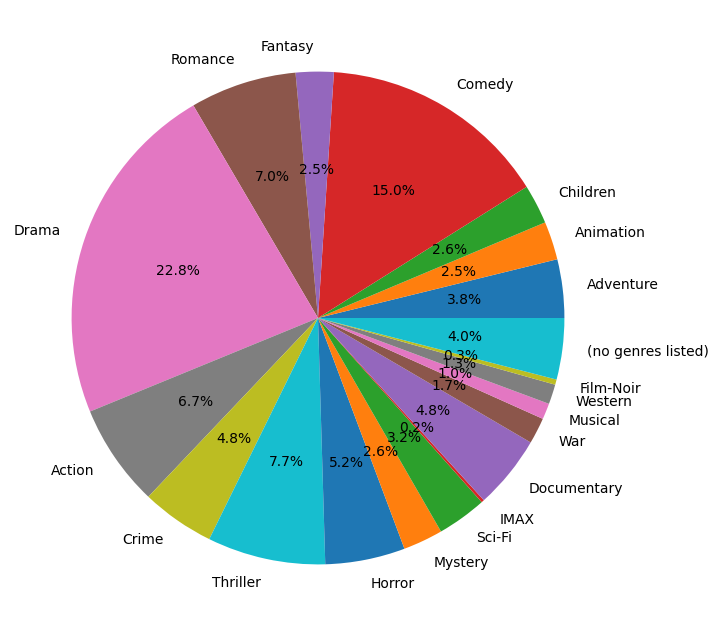

In [27]:
plt.figure(figsize=(8, 8))
plt.pie(genres_counts.values(), labels=genres_counts.keys(), autopct='%1.1f%%')
plt.show()

Жанры это категориальные фичи, перейдем от них к численным.  

In [28]:
for cat in genres_counts.keys():
    movies_df[cat] = movies_df['genres'].apply(lambda x: int(cat in x.split('|')))

In [29]:
del movies_df['genres']

In [30]:
movies_df.head(1)

,movieId,title,Adventure,Animation,Children,Comedy,Fantasy,Romance,Drama,Action,...,Horror,Mystery,Sci-Fi,IMAX,Documentary,War,Musical,Western,Film-Noir,(no genres listed)
0,1,Toy Story (1995),1,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Links

In [59]:
links_df = pd.read_csv(dataset_path / 'links.csv')
links_df

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0
...,...,...,...
58093,193876,38566,78251.0
58094,193878,1754787,87558.0
58095,193880,5847740,422666.0
58096,193882,4453756,454439.0


### Tag genom (genome-tags.csv)

In [60]:
genome_tags_df = pd.read_csv(dataset_path / 'genome-tags.csv')
genome_tags_df

,tagId,tag
0,1,007
1,2,007 (series)
2,3,18th century
3,4,1920s
4,5,1930s
...,...,...
1123,1124,writing
1124,1125,wuxia
1125,1126,wwii
1126,1127,zombie


# Approaches

- Restricted Boltzmann Machines (RBM) for collaborative filtering
- Neural Collaborative Filtering (NCF)
- AutoRec
- CDAE

Вышеперечисленные методы игнорируют порядок элементов поведения (например лайков).

Эту проблему пытались устранить:
- Markov Decision Processes (MDPs) 
- Factorizing Personalized Markov Chains (FPMC)

Методы основанные на RNN:
- GRU4Rec
- Dynamic REcurrent bAsket Model (DREAM)
- user-based GRU
- attention-based GRU (NARM)

Другие подходы:
- Convolutional Sequence Model (Caser)
- Memory Network
- STAMP

Подход через трансформер:
-  SASRec

Подход через BERT:
- **BERT4REC**

Библиотека основанная на трансформерах из huggungface:
- [**Transformers4Rec**](https://github.com/NVIDIA-Merlin/Transformers4Rec/)








Для решения задачи будем использовать кастомную модель на основе берт потому, что это самая популярная модель основанная на трансформере. Берт показывает отличные результаты во многих задачах, в частности в задачах RecSys.

## How to make user vectors?

У юзера есть видео, которые он оценивал или к которым писал комментарий. Пусть `X` - множество векторов этих видео. Разделим `X` на `X_train` и `next_vector`, где `next_vector` это один вектор. При чем в качестве `next_vector` возьмем вектор фильма, которому юзер дал наивысшую оценку. Таким образом `next_vector` это самый подходящий фильм для юзера и мы будем стараться сделать вектор для юзера как можно более похожим на `next_vector`.

На вход модель подаются векторы из `X_train` и модель учится предсказывать вектор `next_vector`.

Предсказанный вектор `next_vector_prediction` будем считать вектором юзера.

Заместо обычных векторов из `relevance_matrix`, полученных ранее, будем использовать 3 типа фичей:
- `ranking`, который юзер дал текущему видео
- `movie genre`
- вектор из `relevance_matrix`

Таким образом, если юзер низко оценил видео, то оно почти не будет участвовать в предсказании следующего видео. Также мы учитываем какой жанр был у видео, ведь если юзер плохо оценил определенные жанры, то фильмы такого жанра почти не должны влиять на предсказание следующего видео.

# Data preparation

Следующие операции требуют **~17 GB RAM**, если RAM не хватает нужно перейти к шагу **Make datasets for Trainer**, где скачиваются необходимые для обучения результаты.

In [ ]:
sequential_features_df = ratings_df.merge(movies_df, on=['movieId'], how='left')
sequential_features_df

In [ ]:
del sequential_features_df['days_y']

In [ ]:
sequential_features_df.rename(columns={"days_x": "day"}, inplace=True)

Сохранять как csv не будем потому, что это дольше, чем сделать join заново.

In [7]:
ids = np.array(ratings_df['userId'].unique())

In [9]:
np.random.shuffle(ids)
train_len = int(0.7 * len(ids))
train_ids = ids[:train_len]
valid_ids = ids[train_len:]

In [10]:
np.save('./dataset/train_ids.npy', train_ids)
np.save('./dataset/valid_ids.npy', valid_ids)

## Make sequential features

### Dimension reduction

Векотры для видео из relevance_matrix имеют размерность 1128, что очень много. Умньшим размерность до 64

In [19]:
relevance_matrix.shape

(13176, 1128)

In [20]:
svd = TruncatedSVD(n_components=80, n_iter=7, random_state=seed)
relevance_matrix_reducted = svd.fit_transform(relevance_matrix)
relevance_matrix_reducted.shape

(13176, 80)

In [31]:
# Для удобства оставим только фичи жанра
del movies_df['title']

In [32]:
movies_df.set_index('movieId', inplace=True)

In [33]:
index2movieId = {v: k for k, v in movieId2index.items()}

Также мы можем добавить и нформацию о жанре фильма. Сконкатенируем вектор жанра с полученными векторами.

In [34]:
emb_dim_with_genres = movies_df.shape[1] + relevance_matrix_reducted.shape[1]
length = relevance_matrix_reducted.shape[0]
movies_vectors_with_genres = np.ones((length, emb_dim_with_genres))

for i in range(length):
    movies_vectors_with_genres[i] = np.concatenate((movies_df.loc[index2movieId[i]], 
                                                    relevance_matrix_reducted[i]))
movies_vectors_with_genres.shape

(13176, 100)

In [35]:
# Cнова сделаем уменьшение размерности.
svd = TruncatedSVD(n_components=64, n_iter=7, random_state=seed)
movies_vectors = svd.fit_transform(movies_vectors_with_genres)
movies_vectors.shape

(13176, 64)

In [36]:
movies_vectors = torch.tensor(movies_vectors)

In [37]:
torch.save(movies_vectors, './dataset/movies_vectors.pt')

# Loading model

In [6]:
from transformers import AutoModelForSequenceClassification

bert = AutoModelForSequenceClassification.from_pretrained("bert-base-cased", num_labels=64)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

In [7]:
# Посмотрим на архитектуру сети
bert

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [8]:
class BertForUsers(nn.Module):
    '''Модель из частей bert для работы с юзерами'''
    def __init__(self, bert):
        super().__init__()
        self.linear = nn.Linear(64, 768)
        self.layer0 = bert.bert.encoder.layer[0]
        self.layer1 = bert.bert.encoder.layer[1]
        self.pooler = bert.bert.pooler
        self.dropout = bert.dropout
        self.classifier = bert.classifier
    
    def forward(self, *args, **kwargs):
        if self.training:
            return self.forward_train(*args, **kwargs)
        return self.forward_eval(*args, **kwargs)
    
    def forward_train(self, x):
        # [batch_size, 512, 64]
        
        x = self.linear(x)
        # [batch_size, 512, 768]
        
        x = self.layer0(x)[0]
        x = self.layer1(x)[0]
        # [batch_size, 512, 768]
        
        x = self.pooler(x)
        # [batch_size, 768]
        
        x = self.classifier(x)
        # [batch_size, 64]
        
        return x
    
    def forward_eval(self, input=None, target=None):
        return self.forward_train(input)

In [9]:
model = BertForUsers(bert.to(device)).to(device)
# Посмотрим на архитектуру сети
model

BertForUsers(
  (linear): Linear(in_features=64, out_features=768, bias=True)
  (layer0): BertLayer(
    (attention): BertAttention(
      (self): BertSelfAttention(
        (query): Linear(in_features=768, out_features=768, bias=True)
        (key): Linear(in_features=768, out_features=768, bias=True)
        (value): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (output): BertSelfOutput(
        (dense): Linear(in_features=768, out_features=768, bias=True)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (intermediate): BertIntermediate(
      (dense): Linear(in_features=768, out_features=3072, bias=True)
      (intermediate_act_fn): GELUActivation()
    )
    (output): BertOutput(
      (dense): Linear(in_features=3072, out_features=768, bias=True)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
  

In [42]:
shutil.make_archive('./dataset', 'zip', './dataset')

'/content/drive/MyDrive/vk/dataset.zip'

# Make datasets for Trainer

Загрузим все необходимое

In [10]:
data_for_collate_fn = Path('/kaggle/input/data-for-collate-fn')
with open(data_for_collate_fn / 'movieId2index.pkl', 'rb') as f:
    movieId2index = pickle.load(f)
movies_vectors = torch.load(data_for_collate_fn / 'movies_vectors.pt')
train_ids = np.load(data_for_collate_fn / 'train_ids.npy')
valid_ids = np.load(data_for_collate_fn / 'valid_ids.npy')

In [11]:
movies_vectors = movies_vectors.to(device)

В функции ниже создаем бач по набору id юзеров. Для каждого фильма, что смотрел юзер умножаем вектор из `movies_vectors` на рейтинг из `ratings_df`, который дал юзер. Таким образом если оценка фильма -1, то для этого фильма мы возьмем вектор направленный в противоположную сторону. Это будет означать, что предпочтения юзера находятся в противоположной части векторного пространства.

В качестве таргета выбираем вектор фильма с наибольшим рейтингом.

In [12]:
def collate_fn(user_ids):
    '''Создает бачи для DataLoader'''
    input_tensor = torch.zeros((batch_size, max_seq_len, emb_dim))
    target_tensor = torch.zeros((batch_size, emb_dim))
    for i, uid in enumerate(user_ids):
        y = ratings_df[ratings_df['userId'] == uid]
        argmax = y['rating'].argmax()
        argmax_index = y.index[0] + argmax
        
        # В качестве таргета выбираем вектор фильма с наибольшим рейтингом.
        target_movie_id = y[y.index == argmax_index]['movieId']
        index = movieId2index[target_movie_id.item()]
        target_tensor[i] = movies_vectors[index]
        
        y_train =  y[y.index != argmax_index]
        input_movie_ids = y_train['movieId'][:512]
        ratings = y_train['rating'][:512]
        
        for j, movie_id in enumerate(input_movie_ids):
            index = movieId2index[movie_id]
            input_tensor[i][j] = movies_vectors[index]
        
        for j, rate in enumerate(ratings):
            # Умножаем вектор фильма на рейтинг
            input_tensor[i][j] = rate * input_tensor[i][j]
        
    
    return {'input': input_tensor, 'target': target_tensor}

In [13]:
batch = collate_fn(train_ids[:2])
print(batch['input'].shape)
print(batch['input'].device)
print(batch['target'].shape)
print(batch['target'].device)

torch.Size([8, 512, 64])
cpu
torch.Size([8, 64])
cpu


In [14]:
# насколько много юзеров?
len(train_ids), len(valid_ids)

(194240, 83247)

Обучение на 4 эпохах всех юзеров займет больше 10 часов. Заместо этого продемонстрируем корректное обучение на маленькой части датасета.

In [15]:
train_ids = train_ids[:len(train_ids) // 64]
valid_ids = valid_ids[:len(valid_ids) // 64]

In [16]:
class UsersDataset(Dataset):
    def __init__(self, data):
        data = np.array(data)
        indicies = shuffle(np.arange(data.shape[0]))
        self.data = data[indicies]
        
    def __getitem__(self, idx):
        return self.data[idx]

    def __len__(self):
        return self.data.shape[0]

train_data = UsersDataset(train_ids)
valid_data = UsersDataset(valid_ids)

In [17]:
len(train_data), len(valid_data)

(3035, 1300)

# Training

Сделаем кастомные compute_metrics и Trainer

In [18]:
def compute_metrics(pred):
    logits, labels = pred
    dist = 0
    for i in range(len(logits)):
        dist += cosine_distances(logits[i].reshape(1, -1), labels[i].reshape(1, -1))[0][0]
    return {'cosine_distance': dist / len(logits)}

In [19]:
OUTPUT_DIR = "./train_results"
training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    do_train=True,
    do_eval=True,
    evaluation_strategy="epoch",
    learning_rate=1e-4,
    per_device_train_batch_size=batch_size // 2,
    per_device_eval_batch_size=batch_size // 2,
    num_train_epochs=4,
    weight_decay=0.01,
    save_strategy="epoch",
    save_total_limit=1,
    label_names=["target"],
    no_cuda=False,
    seed=seed,
    dataloader_pin_memory=True,
    dataloader_num_workers=0,
    report_to="wandb",
    lr_scheduler_type=transformers.SchedulerType.COSINE,
    load_best_model_at_end=True,
)

In [20]:
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        outputs = model(inputs['input'].to(device))
        
        loss_func = torch.nn.CosineEmbeddingLoss()
        ones = torch.ones((outputs.shape[0],)).to(device)
        loss = loss_func(outputs, inputs['target'].to(device), ones)
        
        # если не оборачивать outputs в словарь, то обрезается первый элемент
        return (loss, {'outputs': outputs}) if return_outputs else loss

In [21]:
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=valid_data,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
)

In [22]:
trainer.train()

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss,Cosine Distance
1,No log,0.155768,0.154461
2,0.167500,0.148915,0.147592
3,0.148000,0.147497,0.146159
4,0.141800,0.146615,0.145284


TrainOutput(global_step=1520, training_loss=0.15257461384723062, metrics={'train_runtime': 880.2656, 'train_samples_per_second': 13.791, 'train_steps_per_second': 1.727, 'total_flos': 0.0, 'train_loss': 0.15257461384723062, 'epoch': 4.0})

In [23]:
shutil.make_archive(OUTPUT_DIR, 'zip', OUTPUT_DIR)

'/kaggle/working/train_results.zip'

# Sources

В данном исследовании использовался датасет: https://grouplens.org/datasets/movielens/latest/

F. Maxwell Harper and Joseph A. Konstan. 2015. The MovieLens Datasets: History and Context. ACM Transactions on Interactive Intelligent Systems (TiiS) 5, 4: 19:1–19:19. https://doi.org/10.1145/2827872

Jesse Vig, Shilad Sen, and John Riedl. 2012. The Tag Genome: Encoding Community Knowledge to Support Novel Interaction. ACM Trans. Interact. Intell. Syst. 2, 3: 13:1–13:44. https://doi.org/10.1145/2362394.2362395